In [1]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [60]:
def extract_features(video_path):
    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)
    # Load video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Variables to store intensity values
    intensity_values = []
    # Process each frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Convert to RGB (MediaPipe requires RGB images)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Process the frame with MediaPipe Face Mesh
        results = face_mesh.process(rgb_frame)
        if results.multi_face_landmarks:
            # Assume only one face is detected
            face_landmarks = results.multi_face_landmarks[0]
            # Get frame dimensions
            h, w, _ = frame.shape
            # Extract specific landmarks
            nose_tip = face_landmarks.landmark[4]
            upper_lip = face_landmarks.landmark[13]
            # Convert normalized landmark coordinates to pixel values
            nose_tip_x = int(nose_tip.x * w)
            nose_tip_y = int(nose_tip.y * h)
            upper_lip_x = int(upper_lip.x * w)
            upper_lip_y = int(upper_lip.y * h)
            # Define the ROI (below nose and above lips)
            horizontal_expansion = 80
            vertical_expansion_above = 10
            vertical_expansion_below = 10
            roi_x1 = max(0, nose_tip_x - horizontal_expansion)
            roi_x2 = min(w, nose_tip_x + horizontal_expansion)
            roi_y1 = max(0, nose_tip_y - vertical_expansion_above)
            roi_y2 = min(h, upper_lip_y + vertical_expansion_below)
            # Extract the ROI
            roi = frame[roi_y1:roi_y2, roi_x1:roi_x2]
            # Compute the average intensity of the ROI
            intensity = np.mean(roi)
            intensity_values.append(intensity)

    # Release video capture
    cap.release()

    # Convert intensity values to a numpy array
    intensity_values = np.array(intensity_values)

    # Normalize the intensity values
    intensity_values = (intensity_values - np.mean(intensity_values)) / np.std(intensity_values)

    # Apply a bandpass filter to isolate breathing frequency
    def bandpass_filter(signal, lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal)

    # Apply bandpass filter (0.1–0.5 Hz for breathing)
    filtered_signal = bandpass_filter(intensity_values, lowcut=0.1, highcut=0.5, fs=fps)

    # Find peaks in the filtered signal
    peaks, _ = find_peaks(filtered_signal, height=0, distance=fps//2)

    # Calculate breathing rate (breaths per minute)
    breathing_rate = len(peaks) / (frame_count / fps) * 60

    # Return features (e.g., mean intensity, filtered signal stats, peaks, etc.)
    features = {
        "mean_intensity": np.mean(intensity_values),
        "std_intensity": np.std(intensity_values),
        "num_peaks": len(peaks),
        "breathing_rate": breathing_rate,
    }
    return features

In [8]:
# Path to the folder containing your thermal videos
video_folder = "Thermal Videos"

# Get a list of all video files in the folder and sort them
video_files = sorted([f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))])  # Sort files
video_paths = [os.path.join(video_folder, f) for f in video_files]

# Extract features for each video
features_list = []
for video_path in video_paths:
    print(f"Processing: {video_path}")
    try:
        features = extract_features(video_path)
        features["video_file"] = os.path.basename(video_path)  # Add video file name to features
        features_list.append(features)
    except Exception as e:
        print(f"Error processing {video_path}: {e}")

# Convert to DataFrame
df = pd.DataFrame(features_list)

# Add the corresponding breathing rates in the same order as the sorted videos
breathing_rates = [14.5, 17, 18, 20, 21, 16, 18, 15, 19.5, 19, 19, 20, 17, 15, 17.5, 18.5, 16, 20, 23, 20,
                   18.5, 19, 18, 21, 20, 19, 17, 19, 15, 18,
                   19, 19, 19, 15, 14, 19, 19, 17, 15, 20,
                   20, 21, 17,15, 16, 17, 21, 16, 20] 

# Ensure the number of videos matches the number of breathing rates
if len(video_files) != len(breathing_rates):
    raise ValueError("The number of videos does not match the number of breathing rates.")

# Add the breathing rates to the DataFrame
df["breathing_rate"] = breathing_rates
print(df[["video_file", "breathing_rate"]])

Processing: Thermal Videos\1.0.mp4
Processing: Thermal Videos\1.1.mp4
Processing: Thermal Videos\1.2.mp4
Processing: Thermal Videos\1.3.mp4
Processing: Thermal Videos\1.4.mp4
Processing: Thermal Videos\1.5.mp4
Processing: Thermal Videos\1.6.mp4
Processing: Thermal Videos\1.7.mp4
Processing: Thermal Videos\1.8.mp4
Processing: Thermal Videos\1.9.mp4
Processing: Thermal Videos\2.0.mp4
Processing: Thermal Videos\2.1.mp4
Processing: Thermal Videos\2.2.mp4
Processing: Thermal Videos\2.3.mp4
Processing: Thermal Videos\2.4.mp4
Processing: Thermal Videos\2.5.mp4
Processing: Thermal Videos\2.6.mp4
Processing: Thermal Videos\2.7.mp4
Processing: Thermal Videos\2.8.mp4
Processing: Thermal Videos\2.9.mp4
Processing: Thermal Videos\3.0.mp4
Processing: Thermal Videos\3.1.mp4
Processing: Thermal Videos\3.2.mp4
Processing: Thermal Videos\3.3.mp4
Processing: Thermal Videos\3.4.mp4
Processing: Thermal Videos\3.5.mp4
Processing: Thermal Videos\3.6.mp4
Processing: Thermal Videos\3.7.mp4
Processing: Thermal 

In [4]:
print(df.head())  # Show first 5 rows of extracted features

   mean_intensity  std_intensity  num_peaks  breathing_rate video_file
0   -9.279476e-15            1.0          5            14.5    1.0.mp4
1    4.068762e-15            1.0          4            17.0    1.1.mp4
2    7.572207e-15            1.0          7            18.0    1.2.mp4
3   -2.680916e-15            1.0          7            20.0    1.3.mp4
4    8.292806e-16            1.0         24            21.0    1.4.mp4


In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mean_intensity  49 non-null     float64
 1   std_intensity   49 non-null     float64
 2   num_peaks       49 non-null     int64  
 3   breathing_rate  49 non-null     float64
 4   video_file      49 non-null     object 
dtypes: float64(3), int64(1), object(1)
memory usage: 2.0+ KB
None


In [ ]:
#calculate Breathing Rate without the model

In [9]:
num_peaks = 5  # Replace with actual detected peaks
video_duration = 21  # Replace with actual video duration in seconds

breathing_rate = (num_peaks / video_duration) * 60
print(f"Predicted Breathing Rate: {breathing_rate:.2f} breaths per minute")


Predicted Breathing Rate: 14.29 breaths per minute


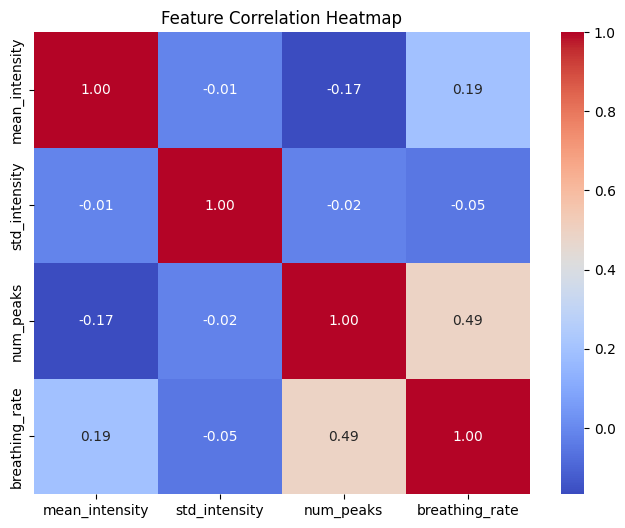

In [28]:
import seaborn as sns
# Drop non-numeric columns
df_numeric = df.drop(columns=["video_file"])

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



In [30]:
# Ensure the video_file column is excluded from X
X = df.drop(columns=["breathing_rate", "video_file"])  # Drop target and non-numeric columns
y = df["breathing_rate"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store the corresponding video file names for the test set
video_test = df.loc[X_test.index, "video_file"]
video_train = df.loc[X_train.index, "video_file"]

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions for the entire dataset
y_pred_all = model.predict(X)  # Predictions for all videos
y_pred_train = model.predict(X_train)  # Predictions for the training set
y_pred_test = model.predict(X_test)  # Predictions for the test set

# Create a DataFrame to associate predictions with video names for all videos
results_all_df = pd.DataFrame({
    "video_file": df["video_file"],  # Video file names
    "actual_breathing_rate": y,  # Actual breathing rates
    "predicted_breathing_rate": y_pred_all  # Predicted breathing rates for all videos
})

# Create a DataFrame for training set predictions
results_train_df = pd.DataFrame({
    "video_file": video_train.reset_index(drop=True),  # Video file names for training set
    "actual_breathing_rate": y_train.reset_index(drop=True),  # Actual breathing rates for training set
    "predicted_breathing_rate": y_pred_train  # Predicted breathing rates for training set
})

# Create a DataFrame for test set predictions
results_test_df = pd.DataFrame({
    "video_file": video_test.reset_index(drop=True),  # Video file names for test set
    "actual_breathing_rate": y_test.reset_index(drop=True),  # Actual breathing rates for test set
    "predicted_breathing_rate": y_pred_test  # Predicted breathing rates for test set
})

# Display the results for the training set
print("\nPredictions for Training Set:")
print(results_train_df)

# Display the results for the test set
print("\nPredictions for Test Set:")
print(results_test_df)


Predictions for Training Set:
   video_file  actual_breathing_rate  predicted_breathing_rate
0     2.2.mp4                   17.0                    17.750
1     1.4.mp4                   21.0                    20.840
2     4.4.mp4                   14.0                    15.130
3     1.8.mp4                   19.5                    19.260
4     1.3.mp4                   20.0                    18.805
5     1.6.mp4                   18.0                    18.465
6     5.0.mp4                   20.0                    18.700
7     5.1.mp4                   21.0                    20.410
8     5.6.mp4                   21.0                    20.045
9     2.5.mp4                   18.5                    18.815
10    1.9.mp4                   19.0                    19.030
11    2.6.mp4                   16.0                    16.275
12    3.4.mp4                   20.0                    19.980
13    4.3.mp4                   15.0                    16.130
14    4.0.mp4           

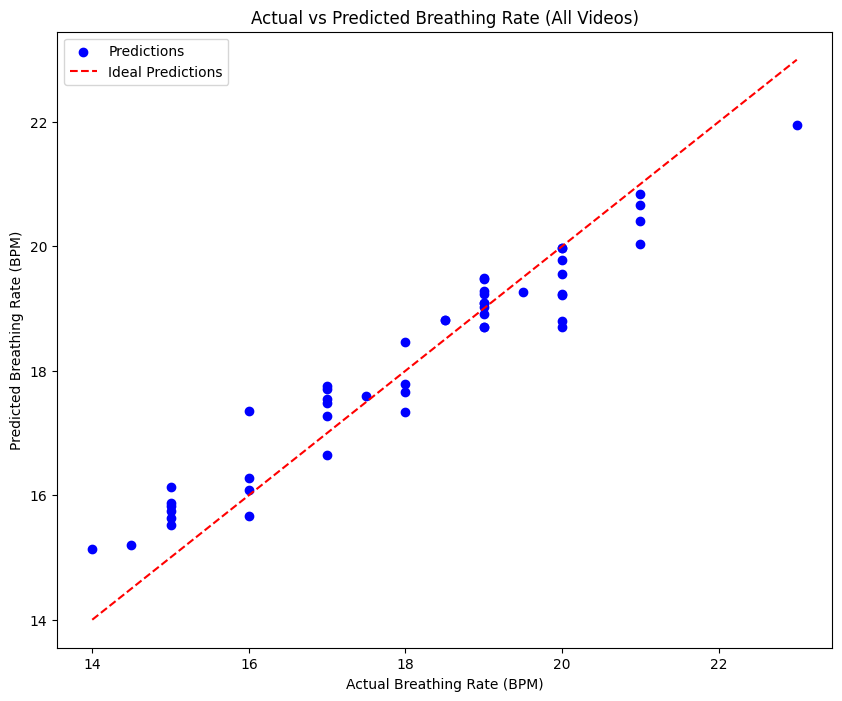

In [25]:
# Plot actual vs predicted breathing rates for all videos
plt.figure(figsize=(10, 8))
plt.scatter(results_all_df["actual_breathing_rate"], results_all_df["predicted_breathing_rate"], color="blue", label="Predictions")
plt.plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="--", label="Ideal Predictions")
plt.xlabel("Actual Breathing Rate (BPM)")
plt.ylabel("Predicted Breathing Rate (BPM)")
plt.title("Actual vs Predicted Breathing Rate (All Videos)")
plt.legend()
plt.show()

In [38]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2, "Predictions": y_pred}
    
    print(f"Model: {name}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("-" * 40)


Model: Random Forest
Mean Absolute Error: 0.46
Mean Squared Error: 0.35
R-squared: 0.88
----------------------------------------
Model: Gradient Boosting
Mean Absolute Error: 0.68
Mean Squared Error: 0.51
R-squared: 0.83
----------------------------------------
Model: XGBoost
Mean Absolute Error: 0.70
Mean Squared Error: 1.20
R-squared: 0.60
----------------------------------------


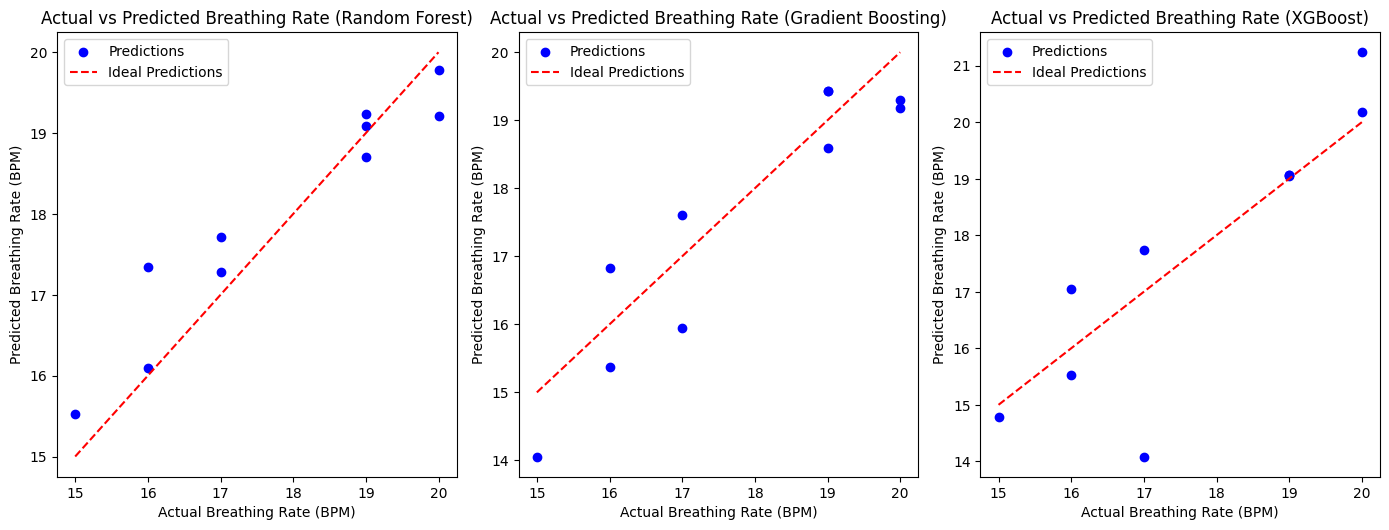

In [39]:
plt.figure(figsize=(14, 10))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(2, 3, i + 1)
    plt.scatter(y_test, result["Predictions"], color="blue", label="Predictions")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal Predictions")
    plt.xlabel("Actual Breathing Rate (BPM)")
    plt.ylabel("Predicted Breathing Rate (BPM)")
    plt.title(f"Actual vs Predicted Breathing Rate ({name})")
    plt.legend()

plt.tight_layout()
plt.show()

In [40]:
import numpy as np
from sklearn.ensemble import VotingRegressor

# Define base models
base_models = [
    ("Random Forest", RandomForestRegressor(n_estimators=50, random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42)),
]

# Ensemble using VotingRegressor (Averaging approach)
ensemble_model = VotingRegressor(estimators=base_models)

# Train and evaluate ensemble model
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Ensemble Model Results:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Ensemble Model Results:
Mean Absolute Error: 0.42
Mean Squared Error: 0.27
R-squared: 0.91


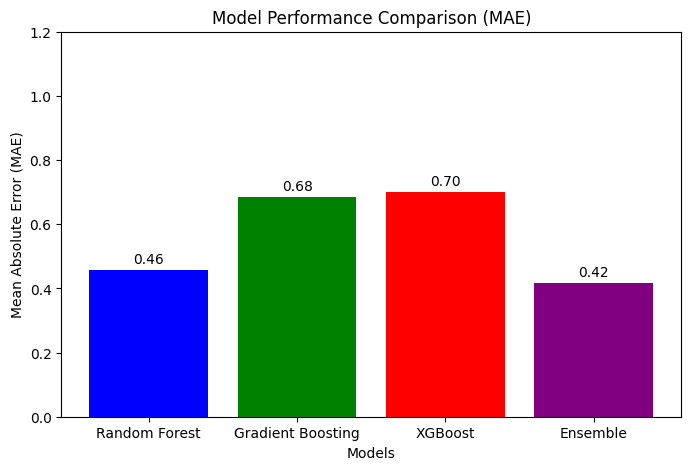

In [43]:
import matplotlib.pyplot as plt

# Model names and their MAE values
model_names = list(results.keys()) + ["Ensemble"]
mae_values = [results[name]["MAE"] for name in results.keys()] + [mae]
colors = ["blue", "green", "red", "purple"]  # Colors for each model

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(model_names, mae_values, color=colors)

# Labels and title
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Performance Comparison (MAE)")
plt.ylim(0, max(mae_values) + 0.5)  # Adjusting the y-axis for better visualization

# Show values on bars
for i, v in enumerate(mae_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()


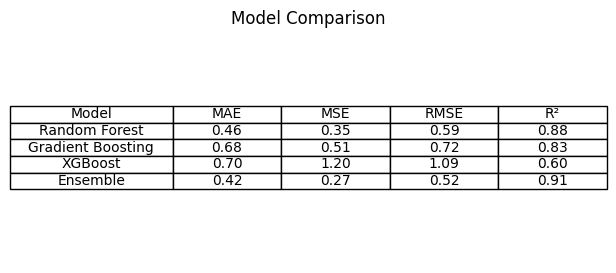

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Collect metrics for all models
models = ["Random Forest", "Gradient Boosting", "XGBoost", "Ensemble"]
mae_values = [results[m]["MAE"] for m in results] + [mae]
mse_values = [results[m]["MSE"] for m in results] + [mse]
r2_values = [results[m]["R2"] for m in results] + [r2]
rmse_values = [np.sqrt(results[m]["MSE"]) for m in results] + [np.sqrt(mse)]

# Create a table-like display
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis("tight")
ax.axis("off")

# Data for display
table_data = [
    ["Model", "MAE", "MSE", "RMSE", "R²"],
    [models[0], f"{mae_values[0]:.2f}", f"{mse_values[0]:.2f}", f"{rmse_values[0]:.2f}", f"{r2_values[0]:.2f}"],
    [models[1], f"{mae_values[1]:.2f}", f"{mse_values[1]:.2f}", f"{rmse_values[1]:.2f}", f"{r2_values[1]:.2f}"],
    [models[2], f"{mae_values[2]:.2f}", f"{mse_values[2]:.2f}", f"{rmse_values[2]:.2f}", f"{r2_values[2]:.2f}"],
    [models[3], f"{mae_values[3]:.2f}", f"{mse_values[3]:.2f}", f"{rmse_values[3]:.2f}", f"{r2_values[3]:.2f}"],
]

# Create the table
ax.table(cellText=table_data, cellLoc="center", loc="center", colWidths=[0.3, 0.2, 0.2, 0.2, 0.2])
plt.title("Model Comparison")
plt.show()


C:\Users\Sonali\breathing_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Sonali\breathing_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\Sonali\breathing_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Sonali\breathing_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


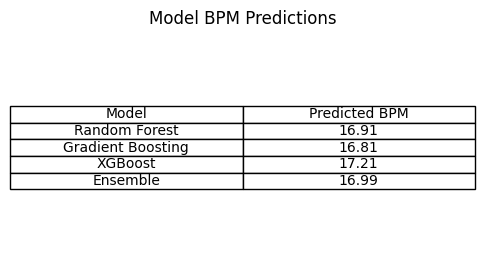

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load pre-trained models
rf_model = joblib.load("random_forest_model.pkl")
gb_model = joblib.load("gradient_boosting_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")
ensemble_model = joblib.load("ensemble_model.pkl")  # Assuming ensemble is also saved

# Set the path to your input video
video_path = "Eg1.mp4"

# Extract features using the existing function
features_dict = extract_features(video_path)  # Ensure this returns a dictionary



# Convert dictionary values to a list
features = list(features_dict.values())  # Ensure it's in correct format
# Remove the 3rd feature and use the 4th one instead
features = [features[0], features[1], features[3]]   # Keep only the first 3 features
# Predict BPM using pre-trained models
predicted_bpm_rf = rf_model.predict([features])[0]
predicted_bpm_gb = gb_model.predict([features])[0]
predicted_bpm_xgb = xgb_model.predict([features])[0]
predicted_bpm_ensemble = ensemble_model.predict([features])[0]


# Display results as a table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("tight")
ax.axis("off")

table_data = [
    ["Model", "Predicted BPM"],
    ["Random Forest", f"{predicted_bpm_rf:.2f}"],
    ["Gradient Boosting", f"{predicted_bpm_gb:.2f}"],
    ["XGBoost", f"{predicted_bpm_xgb:.2f}"],
    ["Ensemble", f"{predicted_bpm_ensemble:.2f}"],
]

ax.table(cellText=table_data, cellLoc="center", loc="center", colWidths=[0.5, 0.5])
plt.title("Model BPM Predictions")
plt.show()
